# Segmenting Retinal Blood Vessels With Deep Neural Networks


In [83]:
import skimage as ski
from skimage import io, exposure, data
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from PIL import Image

In [84]:
filename = 'Data/01_dr.jpg'
mask_filename = 'Data/01_dr_mask.tif'

## Import images

#### Import jpg file

In [85]:
# import images
def loadImage(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    # if len(image.shape) == 3:
    #     image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

# def saveImage(image, filename):
#     data = (image * 255).astype(np.uint8)
#     ski.io.imsave(filename, data)

def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

#### Import tif file

In [86]:
def loadImageTif(mask_filename):
	im = Image.open(mask_filename)
	imarray = np.array(im)
	return imarray

# Find edges on an image

In [87]:
def findEdges(image):
	thresh = 0.2
	image = scipy.ndimage.gaussian_filter(image, sigma=3)
	image = ski.filters.sobel(image) ** 0.5
	binary = (image > thresh) * 255
	binary = np.uint8(binary)
	return binary

# Modifiers

In [121]:
def sharpen(image):
	image = ski.filters.unsharp_mask(image, radius=40, amount=2) #20-40 radius, 1-2 amount
	return image

def brightness(image):
	image = ski.exposure.adjust_gamma(image, 0.1)
	return image

def contrast(image):
	image = ski.exposure.rescale_intensity(image, in_range=(0.1, 0.9))
	# image = ski.exposure.equalize_hist(image)
	return image

def extract_green_channel(image):
	green_channel = image[:, :, 1]
	return green_channel

def green_image(image):
	green_channel = image[:,:,1]
	green_img = np.zeros(image.shape)
	green_img[:,:,1] = green_channel
	return green_img

# Filtr Frangi'ego

In [115]:
# filtr frangi
def frangi(image):
	image = ski.filters.frangi(image, black_ridges=True)
	return image

Original image


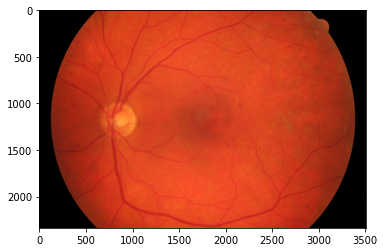

Extract green channel


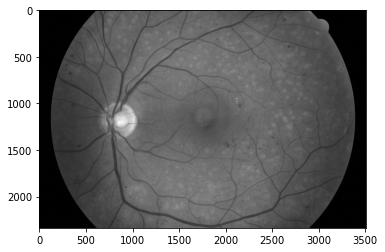

mask


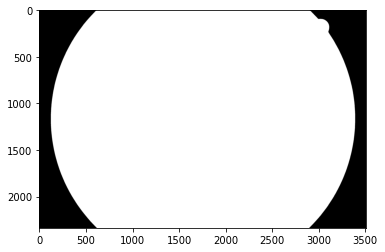

image with mask


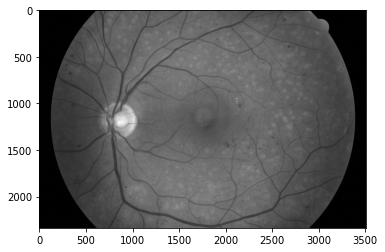

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
48.0
47.0
45.0
47.0
46.0
47.0
46.0
38.0
40.0
35.0
42.0
46.0
47.0
51.0
46.0
40.0
49.0
53.0
54.0
51.0
56.0
50.0
47.0
58.0
60.0
58.0
56.0
58.0
58.0
58.0
57.0
58.0
55.0
Frangi`s filter


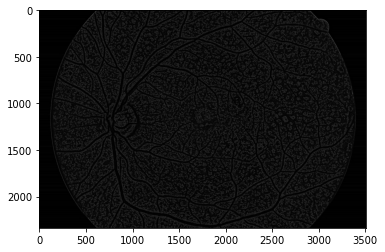

In [130]:
image = loadImage(filename)
mask = loadImageTif(mask_filename)

print("Original image")
showImage(image)

sharpen_img = True
bright_img = True
contrast_img = True

# print("Edited image")
# if sharpen_img:
# 	image = sharpen(image)
# if bright_img:
# 	image = brightness(image)
# if contrast_img:
# 	image = contrast(image)
# showImage(image)

print("Extract green channel")
image = extract_green_channel(image)
showImage(image)

print("mask")
mask = mask[:, :, 0]
showImage(mask)

print("image with mask")
img = image * mask
showImage(image)
for i in range(100,600,10):
	print(img[500][i])

print("Frangi`s filter")
for i in range(len(img)):
	average = np.average(img[i])
	for j in range(len(img[i])):
		if img[i][j] == 0:
			img[i][j] = average

image = frangi(img)
image = brightness(image)
image = frangi(image)
showImage(image)




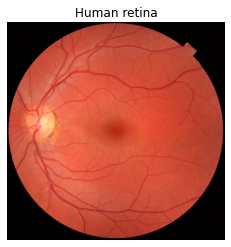

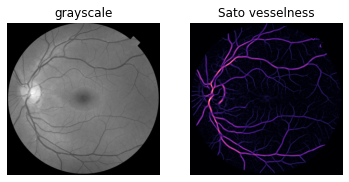

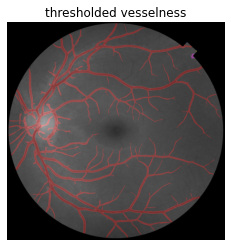

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology

retina_source = data.retina()

_, ax = plt.subplots()
ax.imshow(retina_source)
ax.set_axis_off()
_ = ax.set_title('Human retina')

retina = color.rgb2gray(retina_source)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')

normal


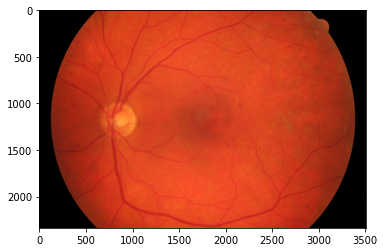

sharpen


C:\Users\Helena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\skimage\filters\_unsharp_mask.py:11: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  blurred = gaussian(image, sigma=radius, mode='reflect')


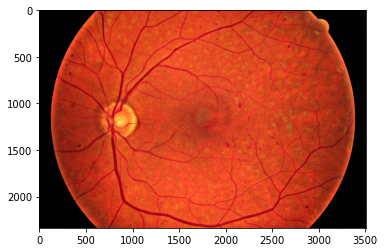

brightness


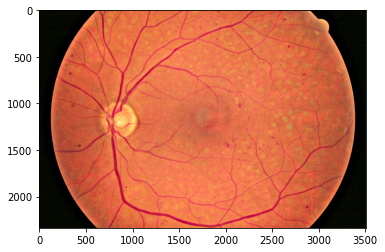

edges


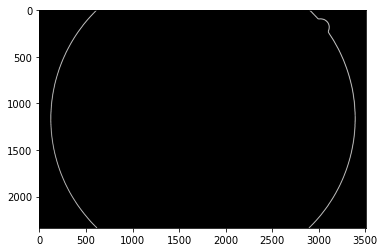

contrast image dark


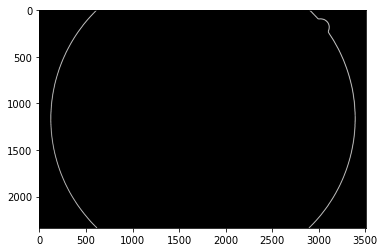

invert color


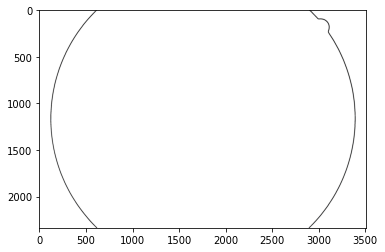

edges


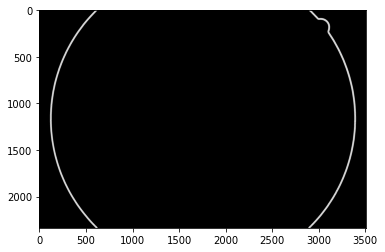

In [91]:
image = loadImage(filename)
image_minmax_scaled = exposure.rescale_intensity(image)
# print("max:", image_minmax_scaled.max())
# print("min:", image_minmax_scaled.min())


# interpolacja liniowa
def interpolate(image):
	min, max = image.min(), image.max()
	arr_subtracted = image - min  # Subtract the minimum
	# array([  0,  38,  98, 203, 248], dtype=uint8)
	arr_divided = arr_subtracted / (max - min)  # Divide by new max
	# array([0.        , 0.15322581, 0.39516129, 0.81854839, 1.        ])
	arr_multiplied = arr_divided * 255  # Multiply by dtype max
	# array([  0.        ,  39.07258065, 100.76612903, 208.72983871,
	#        255.        ])
	# Convert dtype to original uint8
	arr_rescaled = np.asarray(arr_multiplied, dtype=image.dtype)
	# array([  0,  39, 100, 208, 255], dtype=uint8)
	return arr_rescaled

def erase_above_average(image):
	average = image.mean(axis=0).mean(axis=0)
	print(average)
	for i in range(len(image)):
		for j in range(len(image[i])):
			if image[i][j] < average/2:
				image[i][j] = average
	return image



pipeline = [("sharpen", sharpen), ("brightness", brightness), ("edges", findEdges)]

print("normal")
showImage(image)

for title, fun in pipeline:
	print(title)
	image = fun(image)
	showImage(image)

# print("sharpen")
# image = sharpen(image)
# showImage(image)

# print("adjust gamma")
# image = brightness(image)
# showImage(image)

# print("erase_above_average")
# image = erase_above_average(image)
# showImage(image)

# print("Sobel_h")
# image = ski.filters.sobel_h(gamma_img)
# showImage(image)

print("contrast image dark")
image = ski.exposure.rescale_intensity(image, in_range=(0.1, 0.9))
showImage(image)

print("invert color")
image = ski.util.invert(image)
showImage(image)

print("edges")
image = findEdges(image)
showImage(image)


In [92]:
# import matplotlib.pyplot as plt
# img = loadImage(filename)
# avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)

# indices = np.argsort(counts)[::-1]   
# freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
# rows = np.int_(img.shape[0]*freqs)

# dom_patch = np.zeros(shape=img.shape, dtype=np.uint8)
# for i in range(len(rows) - 1):
#     dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6))
# ax0.imshow(avg_patch)
# ax0.set_title('Average color')
# ax0.axis('off')
# ax1.imshow(dom_patch)
# ax1.set_title('Dominant colors')
# ax1.axis('off')
# plt.show(fig)

In [93]:
# import scipy


# def findEdges(images):
#     thresh = 0.2
#     list = []
#     for i in range(0, len(images)):
#         images [i] = scipy.ndimage.gaussian_filter(images[i], sigma=3)
#         images[i] = ski.filters.sobel(images[i]) ** 0.5
#         binary = (images[i] > thresh) * 255
#         binary = np.uint8(binary)
#         list.append(binary)
#     return list